# Weighted ECM clustering vs Traditional ECM clustering
## With WINE dataset

In [1]:
## Importing
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
from evclust.ecm import ecm
from evclust.wecm_outlier import wecm
from evclust.utils import ev_plot, ev_pcaplot, calculate_non_specificity, plotting
import pandas as pd
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import LabelEncoder, MinMaxScaler


   Alcohol  Malicacid   Ash  Alcalinity_of_ash  Magnesium  Total_phenols  \
0    14.23       1.71  2.43               15.6        127           2.80   
1    13.20       1.78  2.14               11.2        100           2.65   
2    13.16       2.36  2.67               18.6        101           2.80   
3    14.37       1.95  2.50               16.8        113           3.85   
4    13.24       2.59  2.87               21.0        118           2.80   

   Flavanoids  Nonflavanoid_phenols  Proanthocyanins  Color_intensity   Hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   0D280_0D315_of_diluted_wines  Proline  
0                        

D:\vtdo\projects\evclust\src\evclust\utils.py:1089: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(data_reduced[i, 0], data_reduced[i, 1], alpha=0.5, c=colors[i], marker=marker_list[i])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


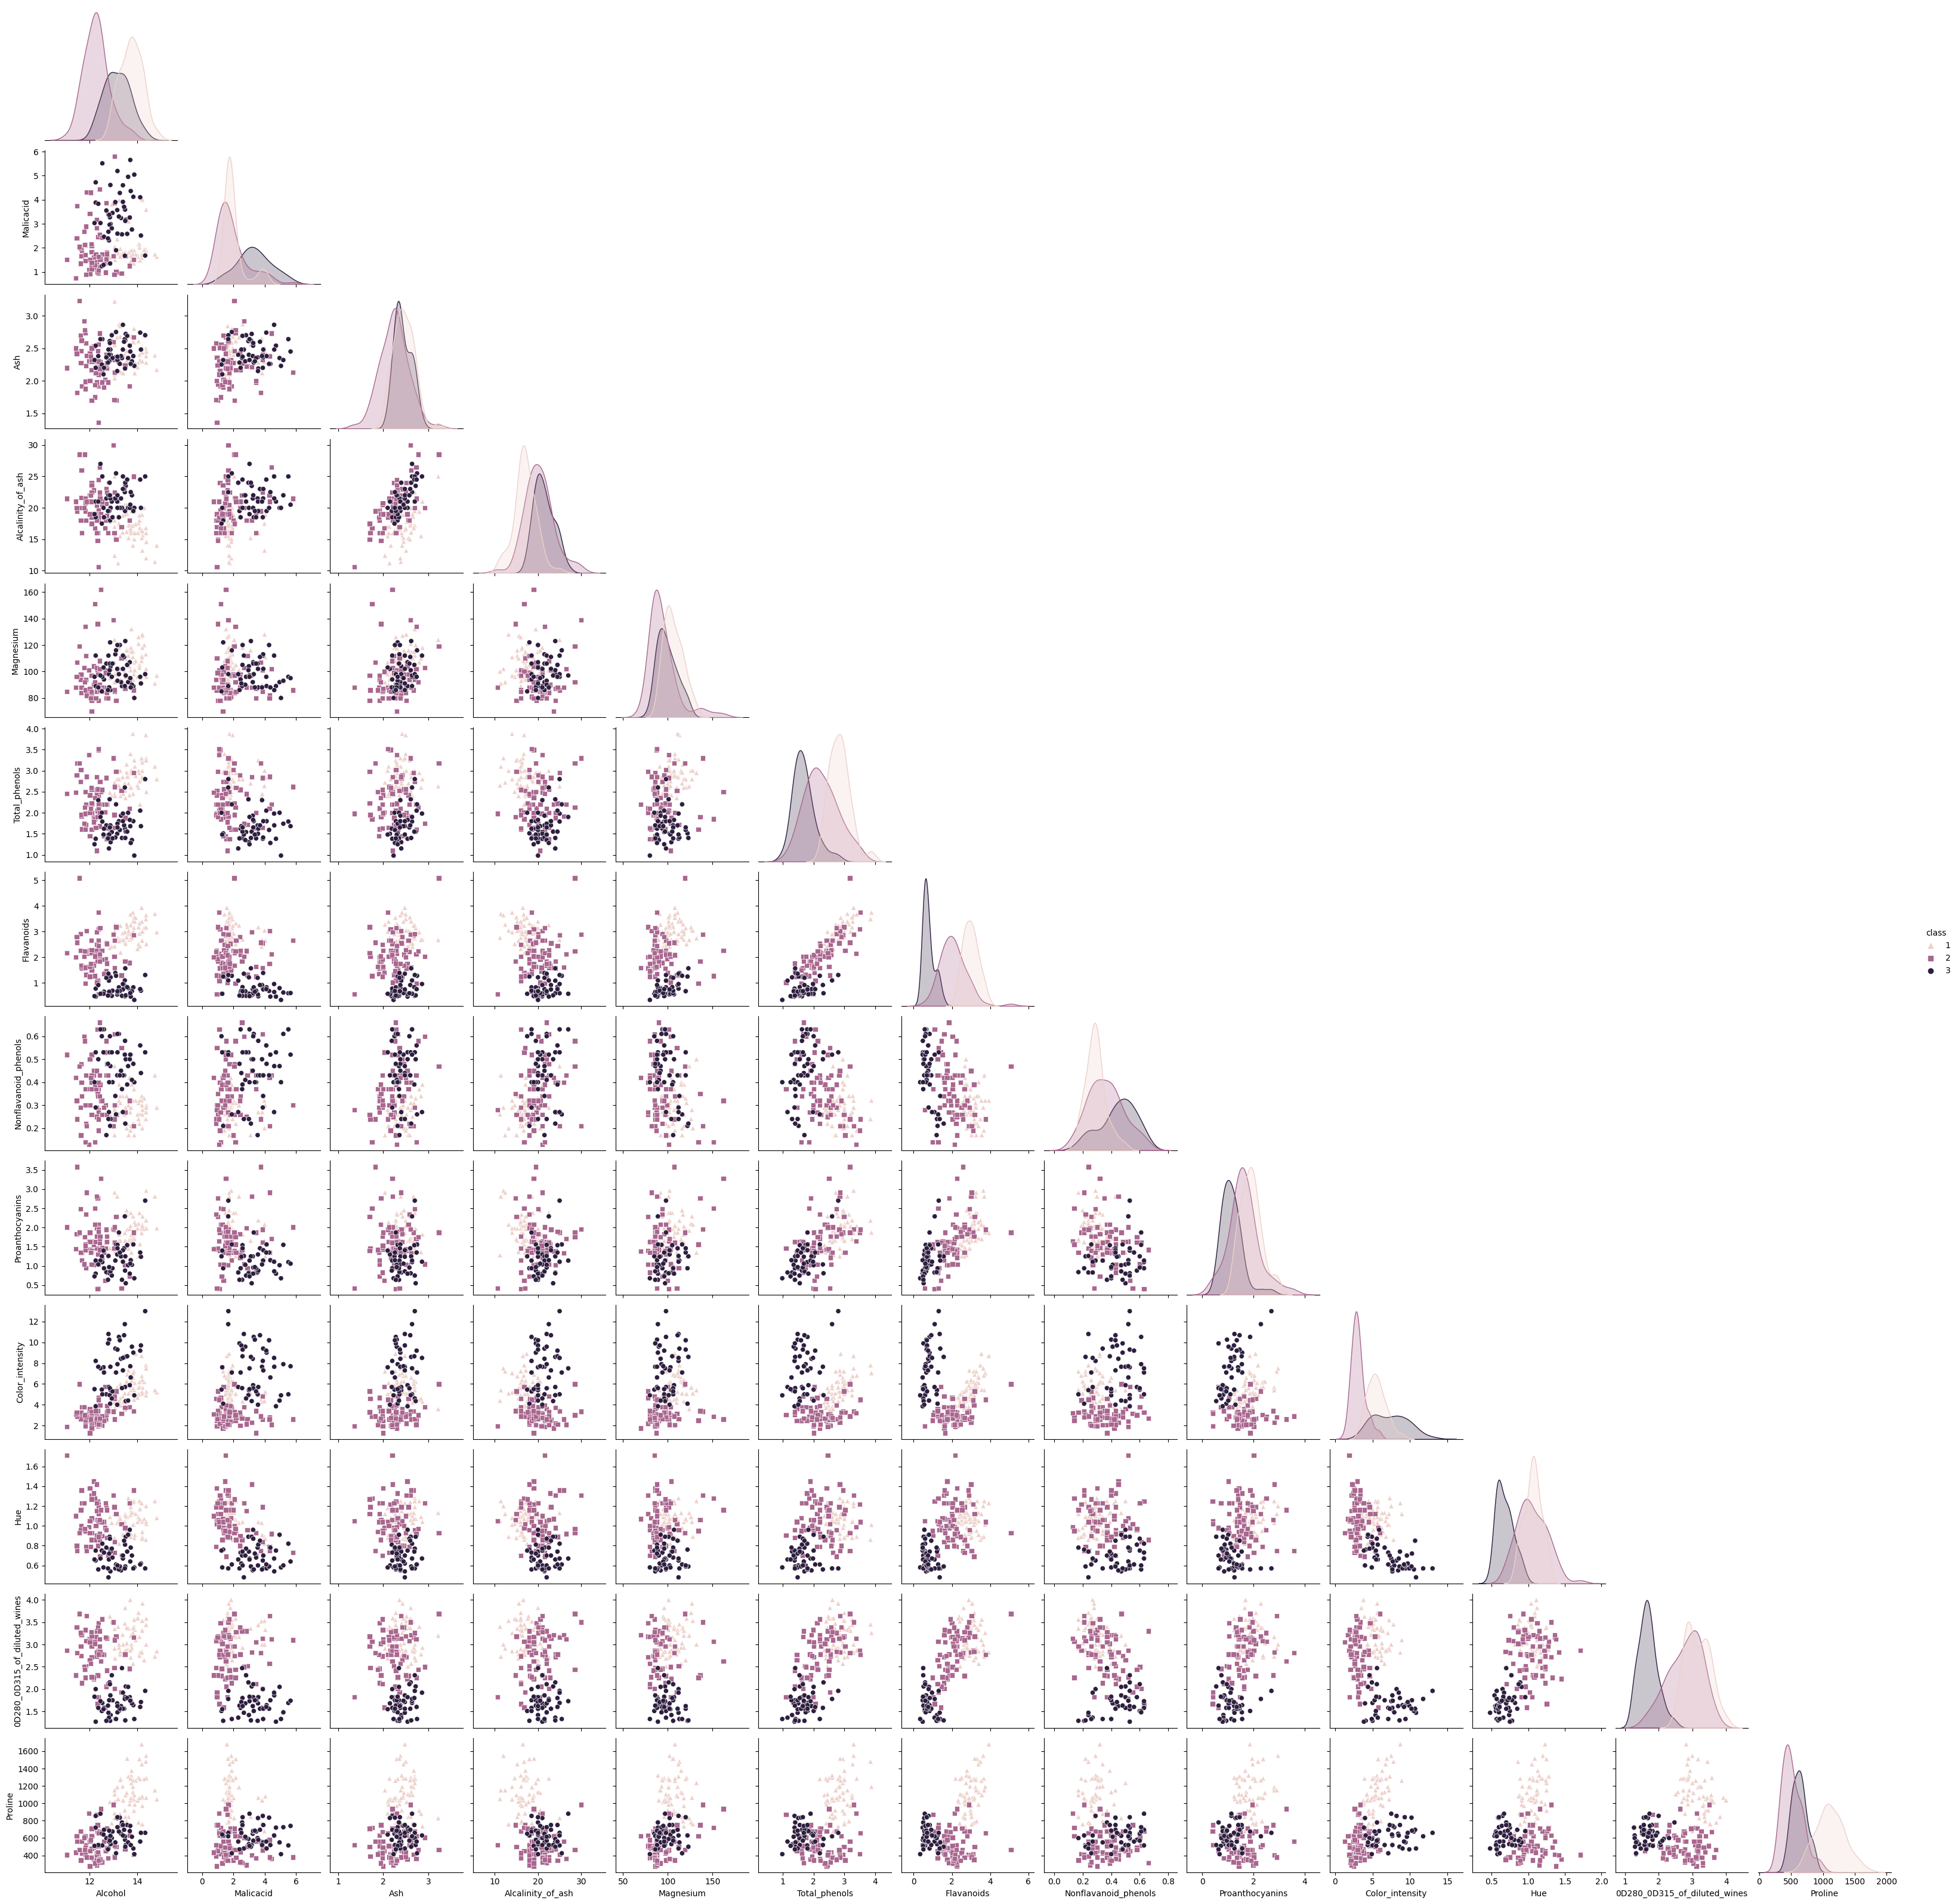

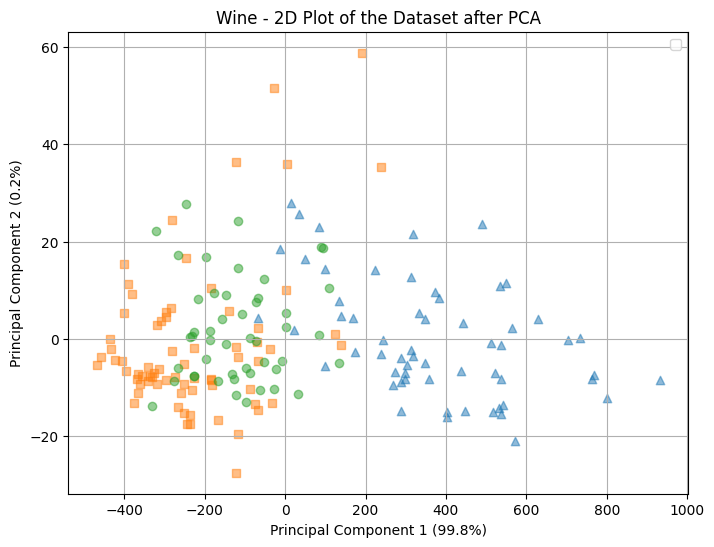

In [2]:
# fetch dataset
iris = fetch_ucirepo(id=109)

# data (as pandas dataframes)
X = pd.DataFrame(iris.data.features)
y = pd.DataFrame(iris.data.targets)

label_column_nm = y.columns[0]
labels_encoder = LabelEncoder()
numeric_labels = labels_encoder.fit_transform(y[label_column_nm])

markers = ['^', 's', 'o']
plotting(X, y, ds_name="Wine", matrix_plot=True, markers=markers)

# Normalization
scaler = MinMaxScaler(feature_range=(0, 1))
X = pd.DataFrame(scaler.fit_transform(X))

## Traditional ECM

In [3]:
%%capture
# Traditional ECM clustering
c=3
delta = np.sqrt(20)
model_list = np.array([])
for i in range(10):
    model = ecm(x=X, c=c, beta=2, alpha=1, delta=delta, init="kmeans")
    model_list = np.append(model_list, model)
    
model_list = sorted(model_list, key=lambda x : x['crit'])
# ARIs
true_labels = numeric_labels
predicted_labels_list = list(map(lambda mod: np.argmax(model['betp'], axis=1), model_list))
ari_list = [adjusted_rand_score(true_labels, predicted_labels) for predicted_labels in predicted_labels_list]

# Non-specificity values of top 10
top_NS = [calculate_non_specificity(model, verbose=False) for model in model_list]

# Normalize mutual infor scores
NMIs = [normalized_mutual_info_score(true_labels, predicted_labels) for predicted_labels in predicted_labels_list]

J values: [17.982198145134515, 17.982198145134515, 17.982198145134515, 17.982198145134518, 17.982218962115617, 17.982251221767502, 17.98225960675476, 17.98225960675476, 17.982288086683923, 17.982347026330853]
ARI values: [0.8348940044607465, 0.8348940044607465, 0.8348940044607465, 0.8348940044607465, 0.8348940044607465, 0.8348940044607465, 0.8348940044607465, 0.8348940044607465, 0.8348940044607465, 0.8348940044607465]
NS values: [1.4094946927566254, 1.389213137395699, 1.4094946927566254, 1.4163427337728927, 1.4095236931953636, 1.4095567469268162, 1.3892124734638598, 1.4163933317112656, 1.379993922451625, 1.3681599957556383]
NMI values: [0.8215490461307173, 0.8215490461307173, 0.8215490461307173, 0.8215490461307173, 0.8215490461307173, 0.8215490461307173, 0.8215490461307173, 0.8215490461307173, 0.8215490461307173, 0.8215490461307173]
Average ARI values: 0.8348940044607465
Average Non-specificity: 1.3997385420186412
Average Normalized mutual infor: 0.8215490461307173
Center: [[0.53335917

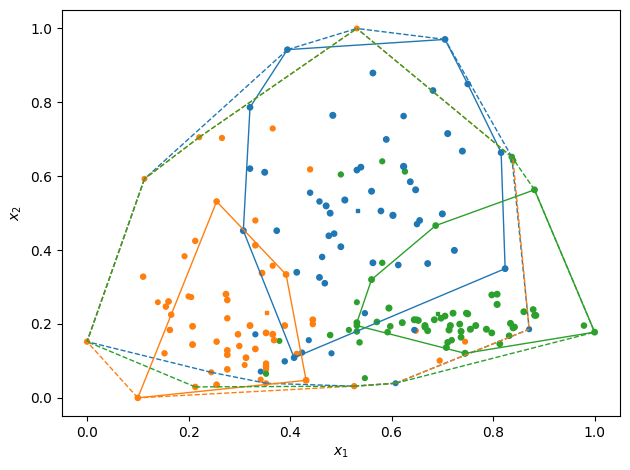

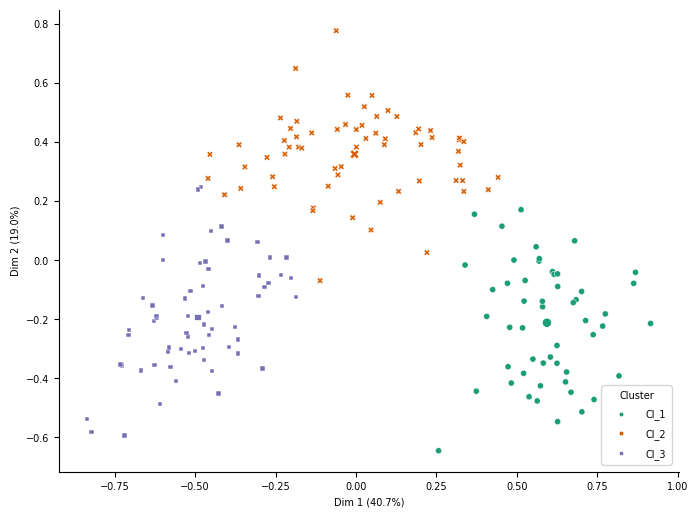

In [4]:
print(f"J values: {[x['crit'] for x in model_list]}")
print(f"ARI values: {ari_list}")
print(f"NS values: {top_NS}")
print(f"NMI values: {NMIs}")
print(f"Average ARI values: {np.mean(ari_list)}")
print(f"Average Non-specificity: {np.mean(top_NS)}")
print(f"Average Normalized mutual infor: {np.mean(NMIs)}")
print(f"Center: {model_list[0]['g']}")
# Plotting the the model with the minimum J value
ev_plot(model_list[0], X=X, cex=20)
ev_pcaplot(data=X, x=model_list[0], normalize=False, cex=20)

## Weighted ECM (WECM)

In [5]:
%%capture
model_list = np.array([])
c = 3
d = X.shape[1]
delta=np.sqrt(20)
W = np.ones((c, d)) * (1/d)
for i in range(10):
    model = wecm(x=X, c=c, W=W, beta=2, alpha=1, delta=delta, ntrials=1, epsi=1e-3, init="kmeans", stopping_factor="center")
    model_list = np.append(model_list, model)

model_list = sorted(model_list, key=lambda mod: model['crit'])

# ARIs
true_labels = numeric_labels
predicted_labels_list = list(map(lambda mod: np.argmax(model['betp'], axis=1), model_list))
ari_list = [adjusted_rand_score(true_labels, predicted_labels) for predicted_labels in predicted_labels_list]

# Non-specificity values of top 10
top_NS = [calculate_non_specificity(model, verbose=False) for model in model_list]

# Normalize mutual infor scores
NMIs = [normalized_mutual_info_score(true_labels, predicted_labels) for predicted_labels in predicted_labels_list]

J values: [0.10066351488029657, 0.10066351488029657, 0.10066351488029657, 0.10066351488029657, 0.10066351488029657, 0.0984713428001537, 0.10066351488029657, 0.10066351488029657, 0.10066351488029657, 0.10066351488029657]
ARI values: [0.8024591068836742, 0.8024591068836742, 0.8024591068836742, 0.8024591068836742, 0.8024591068836742, 0.8024591068836742, 0.8024591068836742, 0.8024591068836742, 0.8024591068836742, 0.8024591068836742]
NS values: [1.385636265415536, 1.3750217645142258, 1.4027579024963492, 1.3750217645142258, 1.3944797113191134, 1.3519832865516261, 1.376140919439511, 1.385636265415536, 1.3944797113191134, 1.385636265415536]
NMI values: [0.7954942800062754, 0.7954942800062754, 0.7954942800062754, 0.7954942800062754, 0.7954942800062754, 0.7954942800062754, 0.7954942800062754, 0.7954942800062754, 0.7954942800062754, 0.7954942800062754]
Average ARI values: 0.8024591068836742
Average Non-specificity: 1.3826793856400774
Average Normalized mutual infor: 0.7954942800062754


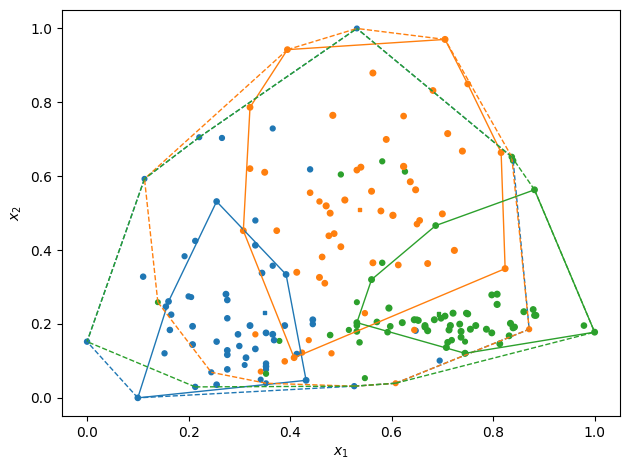

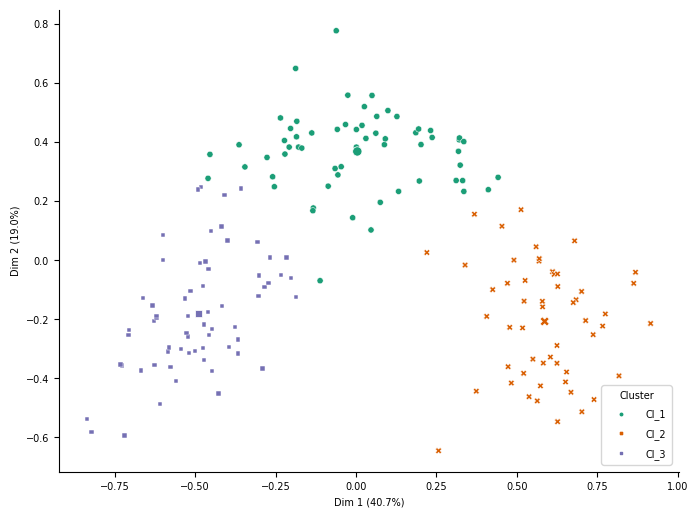

In [6]:
print(f"J values: {[x['crit'] for x in model_list]}")
print(f"ARI values: {ari_list}")
print(f"NS values: {top_NS}")
print(f"NMI values: {NMIs}")
print(f"Average ARI values: {np.mean(ari_list)}")
print(f"Average Non-specificity: {np.mean(top_NS)}")
print(f"Average Normalized mutual infor: {np.mean(NMIs)}")

# Plotting
ev_plot(model_list[0], X=X, cex=20)
ev_pcaplot(data=X, x=model_list[0], normalize=False, cex=20)

In [7]:
top_weights = [model['W'] for model in model_list]
for W in top_weights:
    print(f"\n{W}")


[[0.07399715 0.06975592 0.08180734 0.08065645 0.08387219 0.07518259
  0.08381131 0.06345372 0.08016664 0.0856318  0.07674819 0.06670332
  0.0782134 ]
 [0.07585529 0.0552182  0.09108697 0.08581231 0.08687226 0.08071782
  0.08559405 0.05464635 0.08360908 0.0594016  0.0813008  0.07087637
  0.08900889]
 [0.0677382  0.07986947 0.08572365 0.07763762 0.08218821 0.07643761
  0.0838966  0.07330619 0.07877691 0.08282083 0.08706173 0.06857611
  0.05596686]]

[[0.0677382  0.07986947 0.08572365 0.07763762 0.08218821 0.07643761
  0.0838966  0.07330619 0.07877691 0.08282083 0.08706173 0.06857611
  0.05596686]
 [0.07585529 0.0552182  0.09108697 0.08581231 0.08687226 0.08071782
  0.08559405 0.05464635 0.08360908 0.0594016  0.0813008  0.07087637
  0.08900889]
 [0.07399715 0.06975592 0.08180734 0.08065645 0.08387219 0.07518259
  0.08381131 0.06345372 0.08016664 0.0856318  0.07674819 0.06670332
  0.0782134 ]]

[[0.07585529 0.0552182  0.09108697 0.08581231 0.08687226 0.08071782
  0.08559405 0.05464635 0.0